# SRI Modeling via Lattices

[Link to Slides and Instructions](https://drive.google.com/file/d/1r1zk9aKIZyVWi_BuYKtM-WB53eEnmd9o/view?usp=drive_link)

You can find a binder notebook [here](https://mybinder.org/v2/gh/NightlyScientist/CCBMSummerWorkshop.git/HEAD)

## Lattice Model Definition (and Functions)

In [172]:
# *run this cell first to load the definitions of the model that we need
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import subplots, show, legend, style
import numpy as np
from numpy import zeros, mod, mean
from numba import njit, jit
from IPython.display import clear_output
from random import random

%matplotlib inline

# next-nearest neighbor list
Susceptible, Infected, Immune, Empty = 0, 1, 2, 3

# color our pencils
style.use("seaborn")

# * calculation functions

@njit(fastmath=True)
def nstatus(old, i, j, status, boxl):
    neighborDirections = [(0,1), (1, 0), (-1,0), (0,-1), (1,1), (1,-1), (-1, -1), (-1,1)]
    n = 0
    for dx, dy in neighborDirections:
        if old[mod(i+dx, boxl), mod(j+dy, boxl)] == status:
            n += 1
    return n

@jit(fastmath=True, nopython=True)
def update_grid(old, sickchance, recoverchance, suschance):
    Susceptible, Infected, Immune = 0, 1, 2
    pops = {Susceptible:0, Infected:0, Immune:0}

    new = zeros(old.shape, dtype=np.int32)

    boxl,_ = old.shape
    for i in range(boxl):
        for j in range(boxl):
            if old[i,j] == Immune:
                if random() < suschance:
                    new[i,j] = Susceptible; pops[Susceptible] += 1
                else:
                    new[i,j] = Immune; pops[Immune] += 1
            elif old[i,j] == Susceptible:
                if nstatus(old, i, j, Infected, boxl) > 0 and random() < sickchance:
                    new[i,j] = Infected; pops[Infected] += 1
                else:
                    new[i,j] = Susceptible; pops[Susceptible] += 1
            elif old[i,j] == Infected:
                if random() < recoverchance:
                    new[i,j] = Immune; pops[Immune] += 1
                else:
                    new[i,j] = Infected; pops[Infected] += 1
    return new, pops[Susceptible], pops[Immune], pops[Infected]

def createLandscape(boxl, immune):
    grid = zeros((boxl, boxl), dtype=np.int32)
    pops = {Susceptible:0, Infected:0, Immune:0}
    # infected
    for dx in range(-2,3):
        for dy in range(-2, 3):
            if dx**2 + dy**2 <= 4:
                grid[boxl//2 + dx, boxl//2 + dy] = Infected
    # immune
    for i in range(boxl):
        for j in range(boxl):
            if random() < immune and grid[i,j] == 0:
                grid[i,j] = Immune
            pops[grid[i,j]] += 1
    return grid, [pops[Susceptible]/boxl**2], [pops[Infected]/boxl**2], [pops[Immune]/boxl**2]

# * plotting functions
def update_plot(grid, infected, time, avginfect, healthy, avgHealthy, recovered, avgRecoverd, empty_sites = False, show_recovered=False):
    color = "black" if empty_sites else "yellow"
    statusColors = ListedColormap(["blue", "red", color])
    fig, (ax1,ax2) = subplots(nrows=1, ncols=2, figsize=(16,8))
    fig.tight_layout(pad=3.0)

    ax1.axis('off')
    ax2.set_xlabel('time (days)')
    ax2.set_ylabel('population fraction')
    ax2.set_ylim(0, 1.)

    ax1.imshow(grid, origin="lower", cmap=statusColors, vmin=0, vmax=2)
    ax2.plot(time, infected, marker="^", c="red")
    if show_recovered:
        ax2.plot(time, recovered, marker="^", c="yellow")

    color = "black" if empty_sites else "blue"
    ax2.plot(time, healthy, marker="^", c=color)

    if show_recovered:
        legend([f"Infected ({mean(avginfect):.2f})", f"Healthy ({mean(avgHealthy):.2f})", f"Recoverd ({mean(avgRecoverd):.2f})"], loc="upper left", fontsize=26)
    else:
        legend([f"Infected ({mean(avginfect):.2f})", f"Healthy ({mean(avgHealthy):.2f})"], loc="upper left", fontsize=26)

    clear_output(wait=True)
    show()

def run_simulation(
    boxl = 75, 
    immunefrac = 1.0, 
    sickchance = 1 / 3, 
    recoverchance = 1 / 14, 
    suschance = 1 / 200, 
    days = 1000,
    updatePlotWait = 20,
    empty_sites = False,
    show_recovered = False,
    wait_until_all_recovered = False
):
    grid, susceptible, infected, immune = createLandscape(boxl, immunefrac)
    time = [0]
    avginfect = [infected[0]]
    avgimmune = [immune[0]]
    avgsus = [susceptible[0]]
    N = boxl**2 if not empty_sites else np.ceil(boxl**2 * (1 - immunefrac))

    # rescale immunefrac, sickchance, suschance, rocoverchance to box size
    # immunefrac /= N
    # suschance /= N
    # recoverchance /= N
    # sickchance /= N

    # simulate 
    # update_plot(grid, infected, time, avginfect)
    update_plot(grid, infected, time, avginfect, susceptible, avgsus, immune, avgimmune, 
                empty_sites=empty_sites, show_recovered = show_recovered)

    ith = 0
    for day in range(1,1 + days):
        grid, s, r, i = update_grid(grid, sickchance, recoverchance, suschance)
        if day > 7:
            time.append(day)

            susceptible.append(s / N)
            immune.append(r / N)
            infected.append(i / N)
            avginfect.append(i / N)
            avgimmune.append(r / N)
            avgsus.append(s / N)

            if len(avginfect) > 7:
                avginfect.pop(0)
                avgsus.pop(0)
                avgimmune.pop(0)
        if i == 0 and not wait_until_all_recovered:
            update_plot(grid, infected, time, avginfect, susceptible, avgsus, immune, avgimmune, 
                        empty_sites=empty_sites, show_recovered = show_recovered)
            break
        if day % updatePlotWait == 0:
            update_plot(grid, infected, time, avginfect, susceptible, avgsus, immune, avgimmune, 
                        empty_sites=empty_sites, show_recovered = show_recovered)

/var/folders/xb/d8kknxjs6m7cm_pw00657qs00000gn/T/ipykernel_65468/3908037022.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use("seaborn")


## Activity 1

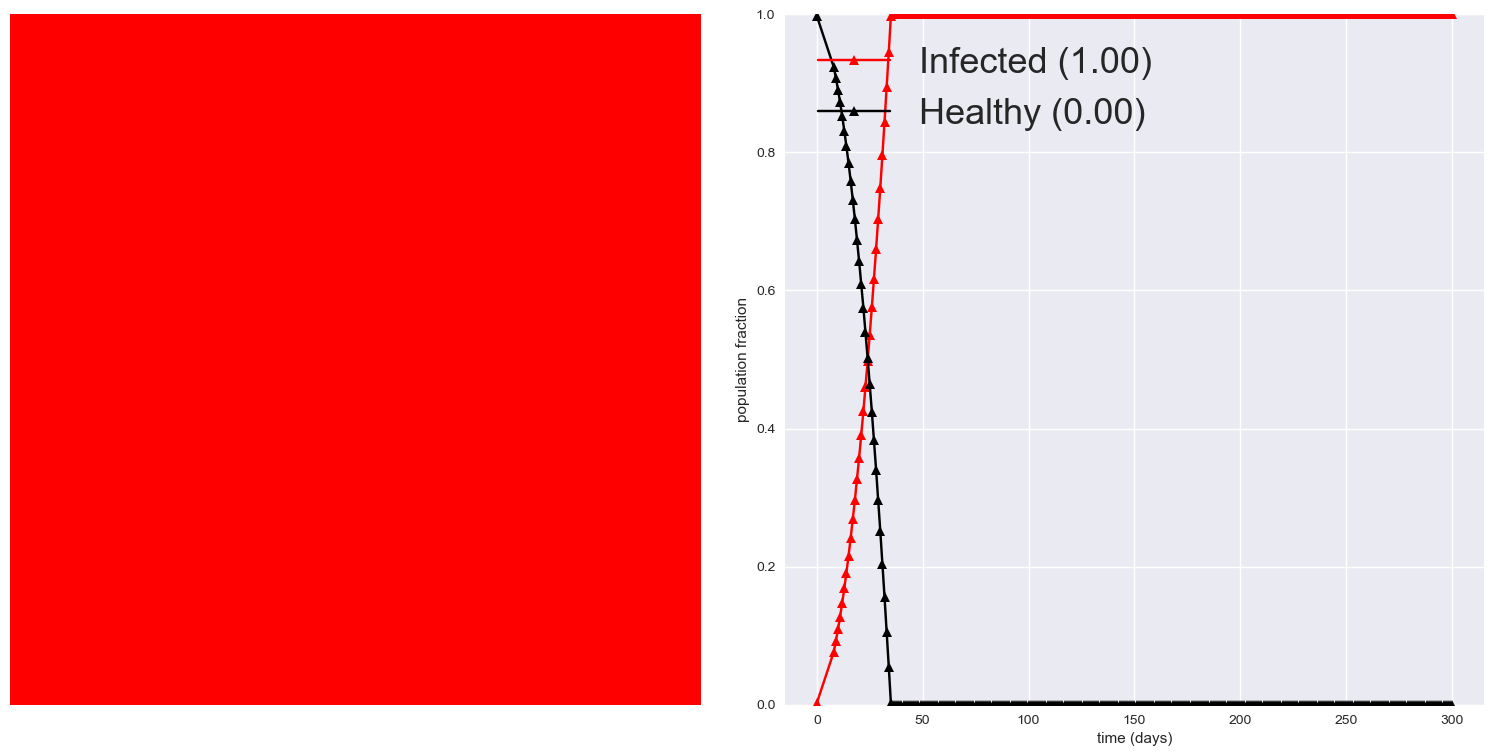

In [173]:
#######################################################################################
# * change these values
healthy_people_coverage = 1.0 # fraction of area that is covered by healthy people that can get sick
################################################################################################
run_simulation(
    immunefrac = 1 - healthy_people_coverage, 
    sickchance = 1, 
    recoverchance = 1 / 10000000, 
    suschance = 1 / 20000000,
    empty_sites=True,
    days = 300
)

## Activity 2

In [ ]:
#######################################################################################
# * change these values
immume_people_coverage = 0.0 # fraction of area that is covered by healthy people that cannot get sick
################################################################################################
run_simulation(
    immunefrac = immume_people_coverage,
    sickchance = 1, 
    recoverchance = 1 / 10000000, 
    suschance = 1 / 20000000,
    days = 300
)

## Activity 3

In [ ]:
#######################################################################################
# * change these values check (20, 20)
days_until_someone_gets_sick = 20 # days before a person next to someone sick will also get sick
days_until_someone_recovers = 1  # days before a person that is sick will recover
################################################################################################
run_simulation(
    immunefrac = 0.,
    sickchance = 1 / days_until_someone_gets_sick, 
    recoverchance = 1 / days_until_someone_recovers, 
    suschance = 1 / 250,
    days = 2000,
    show_recovered = True,
    wait_until_all_recovered = True
)